# Amazon Augmented AI (Amazon A2I) integration with Amazon SageMaker Hosted Endpoint [Example]

This is a custom notebook. Please visit https://github.com/aws-samples/amazon-a2i-sample-jupyter-notebooks for all A2I Sample Notebooks


1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
    1. [Supported Regions](#Supported-Regions)
    2. [Workteam](#Workteam)
    3. [Permissions](#Notebook-Permission)
3. [Client Setup](#Client-Setup)
4. [Create Control Plane Resources](#Create-Control-Plane-Resources)
    1. [Create Human Task UI](#Create-Human-Task-UI)
    2. [Create Flow Definition](#Create-Flow-Definition)
5. [Starting Human Loops](#Scenario-1-:-When-Activation-Conditions-are-met-,-and-HumanLoop-is-created)
    1. [Wait For Workers to Complete Task](#Wait-For-Workers-to-Complete-Task)
    2. [Check Status of Human Loop](#Check-Status-of-Human-Loop)
    3. [View Task Results](#View-Task-Results)


## Introduction

Amazon Augmented AI (Amazon A2I) makes it easy to build the workflows required for human review of ML predictions. Amazon A2I brings human review to all developers, removing the undifferentiated heavy lifting associated with building human review systems or managing large numbers of human reviewers. 

You can create your own workflows for ML models built on Amazon SageMaker or any other tools. Using Amazon A2I, you can allow human reviewers to step in when a model is unable to make a high confidence prediction or to audit its predictions on an on-going basis. 

Learn more here: https://aws.amazon.com/augmented-ai/

In this tutorial, we will show how you can use **Amazon A2I with an Amazon SageMaker Hosted Endpoint.** We will be using an exisiting object detection endpoint in this notebook.

For more in depth instructions, visit https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-getting-started.html

To incorporate Amazon A2I into your human review workflows, you need three resources:

* A **worker task template** to create a worker UI. The worker UI displays your input data, such as documents or images, and instructions to workers. It also provides interactive tools that the worker uses to complete your tasks. For more information, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-instructions-overview.html

* A **human review workflow**, also referred to as a flow definition. You use the flow definition to configure your human workforce and provide information about how to accomplish the human review task. You can create a flow definition in the Amazon Augmented AI console or with Amazon A2I APIs. To learn more about both of these options, see https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html

* A **human loop** to start your human review workflow. When you use one of the built-in task types, the corresponding AWS service creates and starts a human loop on your behalf when the conditions specified in your flow definition are met or for each object if no conditions were specified. When a human loop is triggered, human review tasks are sent to the workers as specified in the flow definition.

When using a custom task type, as this tutorial will show, you start a human loop using the Amazon Augmented AI Runtime API. When you call `start_human_loop()` in your custom application, a task is sent to human reviewers.

### Install Latest SDK

In [1]:
# First, let's get the latest installations of our dependencies
!pip install --upgrade pip
!pip install boto3 --upgrade
!pip install -U botocore

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.0.2)
Requirement already up-to-date: boto3 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (1.12.31)
Requirement already up-to-date: botocore in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (1.15.31)


## Setup
We need to set up the following data:
* `region` - Region to call A2I. Must be us-east-1 for Preview
* `bucket` - A S3 bucket accessible by the given role
    * Used to store the sample images & output results
    * Must be within the same region A2I is called from
* `role` - The IAM role used as part of StartHumanLoop. By default, this notebook will use the execution role
* `workteam` - Group of people to send the work to

### Supported Regions

For the Amazon A2I Preview, the **us-east-1** AWS region is supported. Please ensure that any accompanying resources are created in that region, including S3 buckets.

In [2]:
# A2I is in us-east-1 for Preview
REGION = 'us-east-1'

### Role and Permissions

The AWS IAM Role used to execute the notebook needs to have the following permissions:

* SagemakerFullAccess
* S3 Read/Write Access to the BUCKET listed above
* AmazonSageMakerMechanicalTurkAccess (if using MechanicalTurk as your Workforce)

In [3]:
from sagemaker import get_execution_role
import sagemaker

# Setting Role to the default SageMaker Execution Role
ROLE = get_execution_role()
display(ROLE)

'arn:aws:iam::029454422462:role/service-role/AmazonSageMaker-ExecutionRole-20200325T145934'

#### Setup Bucket and Paths

In [4]:
import os
import boto3
import botocore

sess = sagemaker.Session()
BUCKET = sess.default_bucket()
OUTPUT_PATH = f's3://{BUCKET}/a2i-results'

### Object detection with Amazon SageMaker

To demonstrate A2I with Amazon SageMaker hosted endpoint, we will first train an object detect model using Single Shot multibox Detector (SSD) algorithm and PASCAL VOC dataset. Training a computer vision model with SageMaker is straightforward, please follow [this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) to train a object detection model and host it for real-time prediction. We here provide [a trained model](./model/model.tar.gz) following [the notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb) for demonstration.

#### Load the model and create an endpoint

In [ ]:
import time

# model_data = './model/model.tar.gz'
# model_data_s3_prefix = 'a2i-results/model/model.tar.gz'
# model_data_s3_uri = 's3://%s/%s' % (BUCKET, model_data_s3_prefix)

# s3 = boto3.client('s3', REGION)
# s3.upload_file(model_data, BUCKET, model_data_s3_prefix)

model_data_s3_uri = 's3://aws-sagemaker-augmented-ai-example/model/model.tar.gz'

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = 'DEMO-object-detection-augmented-ai-' + timestamp

image = sagemaker.amazon.amazon_estimator.get_image_uri(REGION, 'object-detection', repo_version='latest')
model = sagemaker.model.Model(model_data_s3_uri, 
                              image, 
                              role = ROLE,
                              predictor_cls = sagemaker.predictor.RealTimePredictor,
                              sagemaker_session = sess)

object_detector = model.deploy(initial_instance_count = 1,
                               instance_type = 'ml.m4.xlarge',
                               endpoint_name = endpoint_name)

object_detector.content_type = 'image/jpeg'

    endpoint = 'object-detection-2020-03-29-01-46-38-378'
    object_detector = sagemaker.predictor.RealTimePredictor(endpoint, sagemaker_session=sess, 
                                                            content_type='image/jpeg')

#### object detection helper functions

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches    
import matplotlib.image as mpimg
import random
import numpy as np

def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        img=mpimg.imread(img_file)
        f, ax = plt.subplots(1, 1)
        ax.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        output = []
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            cls_id = int(klass)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            output.append([class_name, score])
            if score < thresh:
                continue
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = patches.Rectangle((xmin, ymin), xmax - xmin,
                                     ymax - ymin, fill=False,
                                     edgecolor=colors[cls_id],
                                     linewidth=3.5)
            ax.add_patch(rect)
            

            ax.text(xmin, ymin - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                              fontsize=12, color='white')
            
        return f, output
    
def load_and_predict(file_name, predictor, threshold=0.5):
    """
    load an image, make object detection to an predictor, and visualize detections
    Parameters:
    ----------
    file_name : str
        image file location, in str format
    predictor : sagemaker.predictor.RealTimePredictor
        a predictor loaded from hosted endpoint
    threshold : float
        score threshold
    """
    with open(file_name, 'rb') as image:
        f = image.read()
        b = bytearray(f)
    results = predictor.predict(b)
    detections = json.loads(results)
    
    fig, detection_filtered = visualize_detection(file_name, detections['prediction'], 
                                                   object_categories, threshold)
    return results, detection_filtered, fig

### Workteam or Workforce

A workforce is the group of workers that you have selected to label your dataset. You can choose either the Amazon Mechanical Turk workforce, a vendor-managed workforce, or you can create your own private workforce for human reviews. Whichever workforce type you choose, Amazon Augmented AI takes care of sending tasks to workers. 

When you use a private workforce, you also create work teams, a group of workers from your workforce that are assigned to Amazon Augmented AI human review tasks. You can have multiple work teams and can assign one or more work teams to each job.

To create your Workteam, visit the instructions here: https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-management.html

After you have created your workteam, replace YOUR_WORKTEAM_ARN below

In [5]:
WORKTEAM_ARN= "arn:aws:sagemaker:us-east-1:029454422462:workteam/private-crowd/sagemaker-a2i-workforce"

Visit: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-permissions-security.html to add the necessary permissions to your role

## Client Setup

Here we are going to setup the rest of our clients. 

In [6]:
import io
import json
import uuid

# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker', REGION)

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-sagemaker-object-detection-demo-' + timestamp

# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-sagemaker-object-detection-demo-' + timestamp

## Create Control Plane Resources

### Create Human Task UI

Create a human task UI resource, giving a UI template in liquid html. This template will be rendered to the human workers whenever human loop is required.

For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis.

We will be taking an [object detection UI](https://github.com/aws-samples/amazon-a2i-sample-task-uis/blob/master/images/bounding-box.liquid.html) and filling in the proper labels for the use case in the `labels` variable.

In [7]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
                     'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
                     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [8]:
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<crowd-form>
  <crowd-bounding-box
    name="annotatedResult"
    src="{{ task.input.taskObject | grant_read_access }}"
    header="Draw bounding boxes around all the objects in this image"
    labels="['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']"
  >
    <full-instructions header="Bounding Box Instructions" >
      <p>Use the bounding box tool to draw boxes around the requested target of interest:</p>
      <ol>
        <li>Draw a rectangle using your mouse over each instance of the target.</li>
        <li>Make sure the box does not cut into the target, leave a 2 - 3 pixel margin</li>
        <li>
          When targets are overlapping, draw a box around each object,
          include all contiguous parts of the target in the box.
          Do not include parts that are completely overlapped by another object.
        </li>
        <li>
          Do not include parts of the target that cannot be seen,
          even though you think you can interpolate the whole shape of the target.
        </li>
        <li>Avoid shadows, they're not considered as a part of the target.</li>
        <li>If the target goes off the screen, label up to the edge of the image.</li>
      </ol>
    </full-instructions>

    <short-instructions>
      Draw boxes around the requested target of interest.
    </short-instructions>
  </crowd-bounding-box>
</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [9]:
# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-east-1:029454422462:human-task-ui/ui-sagemaker-object-detection-demo-001


### Creating the Flow Definition

In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* The configuration of your worker tasks, including the number of workers that receive a task and time limits to complete tasks.
* Where your output data will be stored.

This demo is going to use the API, but you can optionally create this workflow definition in the console as well. 

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [10]:
create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= ROLE,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Identify and locate the object in an image.",
            "TaskTitle": "Object detection a2i demo"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [11]:
# Describe flow definition - status should be active
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Active
Flow Definition is active


## Human Loops

Now that we have setup our Flow Definition, we are ready to call our object detection endpoint on SageMaker and start our human loops. In this tutorial, we are interested in starting a HumanLoop only if the highest prediction probability score returned by our model for objects detected is less than 50%. 

So, with a bit of logic, we can check the response for each call to the SageMaker endpoint, and if the score is less than 50%, we will kick off a HumanLoop to engage our workforce for a human review. 

#### Sample Data

In [34]:
test_photos = ['sample-a2i-images/pexels-photo-980382.jpeg', # motorcycle
               'sample-a2i-images/pexels-photo-276517.jpeg', # bicycle
               'sample-a2i-images/pexels-photo-1571457.jpeg'] # sofa

!aws s3 sync ./sample-a2i-images/ s3://{BUCKET}/a2i-results/sample-a2i-images/

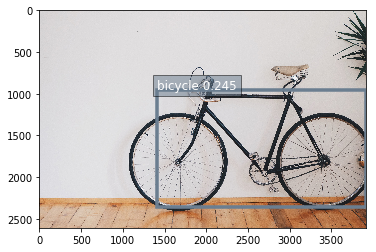

In [33]:
results, detection_filtered, f = load_and_predict(test_photos[1], object_detector, threshold=0.2)

Object detection Confidence Score of motorbike is above than the threshold of 0.50
No human loop created. 

s3://sagemaker-us-east-1-029454422462/a2i-results/sample-a2i-images/pexels-photo-276517.jpeg
Object detection Confidence Score of bicycle is less than the threshold of 0.50
Starting human loop with name: 6addb62e-3dcb-4a30-99df-b58ee6bf7658  

s3://sagemaker-us-east-1-029454422462/a2i-results/sample-a2i-images/pexels-photo-1571457.jpeg
Object detection Confidence Score of sofa is less than the threshold of 0.50
Starting human loop with name: cd919dab-d113-4168-a9d4-bb28dbc079be  



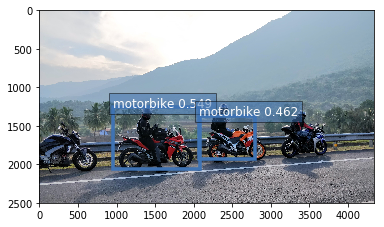

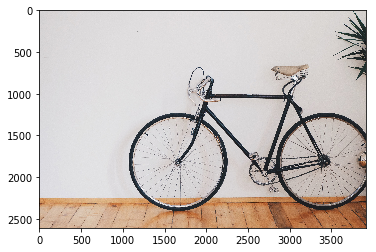

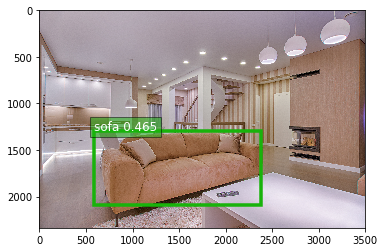

In [25]:
human_loops_started = []
SCORE_THRESHOLD = .50
for fname in test_photos:
    # Call SageMaker endpoint
    response, score_filtered, fig = load_and_predict(fname, object_detector, threshold=0.4)
    # Sort by prediction score
    score_filtered.sort(key=lambda x: x[1], reverse=True)

    # Our condition for when we want to engage a human for review
    if (score_filtered[0][1] < SCORE_THRESHOLD):
        s3_fname='s3://%s/a2i-results/%s' % (BUCKET, fname)
        print(s3_fname)
        humanLoopName = str(uuid.uuid4())
        inputContent = {
            "initialValue": score_filtered[0][0],
            "taskObject": s3_fname
        }
        start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(inputContent)
            }
        )
        human_loops_started.append(humanLoopName)
        print(f'Object detection Confidence Score of %s is less than the threshold of %.2f' % (score_filtered[0][0], SCORE_THRESHOLD))
        print(f'Starting human loop with name: {humanLoopName}  \n')
    else:
        print(f'Object detection Confidence Score of %s is above than the threshold of %.2f' % (score_filtered[0][0], SCORE_THRESHOLD))
        print('No human loop created. \n')

### Check Status of Human Loop

In [26]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
#     print(resp)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

{'ResponseMetadata': {'RequestId': '874989fa-24ad-4cc8-8c8a-0d04b801e7fc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 30 Mar 2020 19:06:00 GMT', 'content-type': 'application/json; charset=UTF-8', 'content-length': '766', 'connection': 'keep-alive', 'x-amzn-requestid': '874989fa-24ad-4cc8-8c8a-0d04b801e7fc', 'access-control-allow-origin': '*', 'x-amz-apigw-id': 'KN9r5FR5oAMF8Hg=', 'x-amzn-trace-id': 'Root=1-5e824318-12a40a8a3f8b4500cf70f773'}, 'RetryAttempts': 0}, 'CreationTime': datetime.datetime(2020, 3, 30, 19, 5, 53, 306000, tzinfo=tzlocal()), 'HumanLoopStatus': 'InProgress', 'HumanLoopName': '6addb62e-3dcb-4a30-99df-b58ee6bf7658', 'HumanLoopArn': 'arn:aws:sagemaker:us-east-1:029454422462:human-loop/6addb62e-3dcb-4a30-99df-b58ee6bf7658', 'FlowDefinitionArn': 'arn:aws:sagemaker:us-east-1:029454422462:flow-definition/fd-sagemaker-object-detection-demo-001', 'HumanLoopOutput': {'OutputS3Uri': 's3://sagemaker-us-east-1-029454422462/a2i-results/fd-sagemaker-object-detection-dem

### Wait For Workers to Complete Task
Since we are using private workteam, we should go to the labling UI to perform the inspection ourselves.

In [27]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://1ulkvlipbf.labeling.us-east-1.sagemaker.aws


### Check Status of Human Loop Again

In [29]:
completed_human_loops = []
for human_loop_name in human_loops_started:
    resp = a2i.describe_human_loop(HumanLoopName=human_loop_name)
    print(f'HumanLoop Name: {human_loop_name}')
    print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
    print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
    print('\n')
    
    if resp["HumanLoopStatus"] == "Completed":
        completed_human_loops.append(resp)

HumanLoop Name: 6addb62e-3dcb-4a30-99df-b58ee6bf7658
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-029454422462/a2i-results/fd-sagemaker-object-detection-demo-001/2020/03/30/19/05/53/6addb62e-3dcb-4a30-99df-b58ee6bf7658/output.json'}


HumanLoop Name: cd919dab-d113-4168-a9d4-bb28dbc079be
HumanLoop Status: Completed
HumanLoop Output Destination: {'OutputS3Uri': 's3://sagemaker-us-east-1-029454422462/a2i-results/fd-sagemaker-object-detection-demo-001/2020/03/30/19/05/54/cd919dab-d113-4168-a9d4-bb28dbc079be/output.json'}




### View Task Results  

Once work is completed, Amazon A2I stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.

In [30]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' +  BUCKET + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=BUCKET, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

{   'flowDefinitionArn': 'arn:aws:sagemaker:us-east-1:029454422462:flow-definition/fd-sagemaker-object-detection-demo-001',
    'humanAnswers': [   {   'answerContent': {   'annotatedResult': {   'boundingBoxes': [   {   'height': 1775,
                                                                                                 'label': 'bicycle',
                                                                                                 'left': 1039,
                                                                                                 'top': 628,
                                                                                                 'width': 2872}],
                                                                        'inputImageProperties': {   'height': 2608,
                                                                                                    'width': 3911}}},
                            'submissionTime': '2020-03-30T23:57:22.773Z',
    

### The End!